In [ ]:
!pip install git+https://github.com/tensorflow/docs

In [ ]:
#imports
from PIL import Image
import numpy as np
from numpy import expand_dims
from numpy import load
from numpy.random import randn
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from keras import Sequential
from keras.initializers import RandomNormal
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.layers import Activation
from tensorflow.keras.utils import plot_model
from pathlib import Path
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

## Load data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_PATH_MAPS = Path("/content/drive/MyDrive/mapsSplit/trainSplit/maps")
DATA_PATH_SATTELITES = Path("/content/drive/MyDrive/mapsSplit/trainSplit/sats")

In [ ]:
def load_real_samples(img_dim = 256):
    maps = np.zeros((0,img_dim, img_dim, 3), 'float32')
    sattelites = np.zeros((0,img_dim, img_dim, 3), 'float32')
    #mapsStr = [str(p) for p in list(DATA_PATH_MAPS.glob('*.jpg'))]
    i = 0
    for p in tqdm(sorted([str(p) for p in list(DATA_PATH_MAPS.glob('*.jpg'))], key=str.lower)):
      img = Image.open(str(p))
      maps = np.append(maps, np.asarray(img)[None,...].astype('float32'), axis=0)
    i = 0
    #satStr = [str(p) for p in list(DATA_PATH_SATTELITES.glob('*.jpg'))]
    for p in tqdm(sorted([str(p) for p in list(DATA_PATH_SATTELITES.glob('*.jpg'))], key=str.lower)):
      img = Image.open(str(p))
      sattelites = np.append(sattelites, np.asarray(img)[None,...].astype('float32'), axis=0)
    # scale from [0,255] to [-1,1]
    map = (maps - 127.5) / 127.5
    sattelite = (sattelites - 127.5) / 127.5
    return [sattelite, map]

In [ ]:
data = load_real_samples(256)
print("Loaded", data[0].shape, data[1].shape)
# define input shape based on the loaded dataset
img_shape = data[0].shape[1:]

  0%|          | 0/1096 [00:00<?, ?it/s]

  0%|          | 0/1096 [00:00<?, ?it/s]

Loaded (1096, 256, 256, 3) (1096, 256, 256, 3)


In [ ]:
img_shape

In [ ]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(data[0][i])
  plt.axis('off')

In [ ]:
fig = plt.figure(figsize=(4, 4))

for i in range(16):
  plt.subplot(4, 4, i+1)
  plt.imshow(data[1][i])
  plt.axis('off')

In [ ]:
# rotate images
def rotate(data):
  lenSats = data[0].shape[0]
  lenMaps = data[1].shape[0]
  for i in tqdm(range(lenSats)):
    data[0] = np.append(data[0], np.rot90(data[0][i])[None,...].astype('float32'), axis=0)
    data[0] = np.append(data[0], np.rot90(data[0][i],2)[None,...].astype('float32'), axis=0)
    data[0] = np.append(data[0], np.rot90(data[0][i],3)[None,...].astype('float32'), axis=0)
    data[1] = np.append(data[1], np.rot90(data[1][i])[None,...].astype('float32'), axis=0)
    data[1] = np.append(data[1], np.rot90(data[1][i],2)[None,...].astype('float32'), axis=0)
    data[1] = np.append(data[0], np.rot90(data[1][i],3)[None,...].astype('float32'), axis=0)
  return data

In [ ]:
data = rotate(data)
print(data[0].shape, data[1].shape)

  0%|          | 0/1096 [00:00<?, ?it/s]

(4384, 256, 256, 3) (4385, 256, 256, 3)


## Make discriminator model

In [13]:
#define discriminator model
def make_discriminator(img_shape = (256,256,3)):
  #input image (sattelite)
  in_img = Input(shape=img_shape)
  #target image - map
  target_img = Input(shape=img_shape)
  merge = Concatenate()([in_img, target_img])

  d = Conv2D(64, (4,4), strides=(2,2), padding='same')(merge)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

	# output
  d = Conv2D(1, (4,4), padding='same')(d)
  out_layer = Activation('sigmoid')(d)
	# define model
  model = Model([in_img, target_img], out_layer)
	# compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  plot_model(model, to_file='/content/drive/MyDrive/SU_Projekt/discriminator.png', show_shapes=True)
  return model

In [14]:
discriminator = make_discriminator()
print(discriminator.output_shape)

(None, 16, 16, 1)


## Make generator model

In [ ]:

#define generator
def make_generator1(img_shape=(256,256,3)):
  init = RandomNormal()
  dim = img_shape[0]
  input_img = Input(shape=img_shape)

  g = Conv2D(dim//2, 4,2,padding='same', kernel_initializer=init)(input_img)
  #g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  
  init = RandomNormal()
  g = Conv2D(dim, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)
  
  init = RandomNormal()
  g = Conv2D(dim*2,4,2, padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2D(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2D(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim//2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  #g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(3, 4, 2, padding='same', kernel_initializer=init)(g)
  
  output_img = Activation('tanh')(g)
  model = Model(input_img, output_img)
  plot_model(model, to_file='/content/drive/MyDrive/SU_Projekt/generator1.png', show_shapes=True)
  return model

In [ ]:

#define generator
def make_generator(img_shape=(256,256,3)):
  init = RandomNormal()
  dim = img_shape[0]
  input_img = Input(shape=img_shape)

  g = Conv2D(dim*2,4,2, padding='same', kernel_initializer=init)(input_img)
  #g = BatchNormalization()(g, training=True)
  g = Activation('relu')(g)

  init = RandomNormal()
  g = Conv2D(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Activation('relu')(g)

  init = RandomNormal()
  g = Conv2D(dim*2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Activation('relu')(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  init = RandomNormal()
  g = Conv2DTranspose(dim//2, 4,2,padding='same', kernel_initializer=init)(g)
  g = BatchNormalization()(g, training=True)
  #g = Dropout(0.5)(g, training=True)
  g = LeakyReLU(alpha=0.2)(g)

  g = Conv2DTranspose(3, 4, 2, padding='same', kernel_initializer=init)(g)
  
  output_img = Activation('tanh')(g)
  model = Model(input_img, output_img)
  plot_model(model, to_file='/content/drive/MyDrive/SU_Projekt/generator.png', show_shapes=True)
  return model

In [ ]:
generator = make_generator()
print(generator.output_shape)

(None, 256, 256, 3)


## Make GAN model

In [ ]:
#define gan
def make_gan(gen_model, dis_model, img_shape):
  dis_model.trainable = False
  # source image
  src_img = Input(shape=(img_shape))
  #connect src image to generator
  gen_out = gen_model(src_img)
  # connect src image gen output to discriminator
  dis_out = dis_model([src_img, gen_out])
  # src img as input
  model = Model(src_img, [dis_out, gen_out])
  #compile model
  opt = Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=['binary_crossentropy', 'mae'], optimizer=opt, loss_weights=[1, 100])
  plot_model(model, to_file='/content/drive/MyDrive/SU_Projekt/gan.png')
  return model

In [ ]:
gan = make_gan(generator, discriminator, img_shape)

In [ ]:
# select real samples from dataset, return image + target
def select_real_samples(data, num_of_samples, shape):
  #split data
  trainSat, trainMap = data
  #generate num_of_samples random numbers between 0 and trainSat.shape[0]
  rndX = randint(0, trainSat.shape[0], num_of_samples)
  # get selected imgs
  X1, X2 = trainSat[rndX], trainMap[rndX]
  # create labels - real class (1)
  Y = np.ones((num_of_samples, shape, shape, 1))
  return [X1, X2, Y]

In [ ]:
# generate fake samples
def generate_fake_samples(gen_model, samples, shape):
  # generate maps
  X = gen_model.predict(samples)
  # create labels - fake class (0)
  Y = np.zeros((len(X), shape, shape, 1))
  return X,Y

## Train the model

In [ ]:
#train model
def train_model(gen_model, dis_model, gan_model, data, num_epochs=300, num_batch=1):
  dis_loss_1 = []
  dis_loss_2 = []
  gan_loss = []
  out_dim = dis_model.output_shape[1]
  trainSat, trainMap = data
  batch_per_epoch = int(len(trainSat)/num_epochs)
  num_of_steps = batch_per_epoch * num_epochs
  for i in tqdm(range(num_of_steps)):
    #select real samples
    realSat, realMap, real_y = select_real_samples(data, num_batch, out_dim)
    #generate fake samples
    fakeMap, fake_y = generate_fake_samples(gen_model, realSat, out_dim)
    #update discriminator for real samples
    dis_loss1 = dis_model.train_on_batch([realSat, realMap], real_y)
    dis_loss_1.append(dis_loss1)
    # update discriminator for fake samples
    dis_loss2 = dis_model.train_on_batch([realSat, fakeMap], fake_y)
    dis_loss_2.append(dis_loss2)
    #update generator
    gan_loss_i = gan_model.train_on_batch(realSat,[real_y, realMap])
    gan_loss.append(gan_loss_i)
  gen_model.save('/content/drive/MyDrive/SU_Projekt/cgan.h5')
  return dis_loss1, dis_loss2, gan_loss

In [ ]:
d1, d2, g = train_model(generator, discriminator, gan, data)

NameError: ignored

In [ ]:
from keras.models import load_model
m = load_model('/content/drive/MyDrive/SU_Projekt/cgan.h5', compile=False)

## Generate maps

In [ ]:
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import expand_dims
from matplotlib import pyplot
import tensorflow as tf
def load_image(filename, size=(256,256)):
    pixels = load_img(filename, target_size=size)
    pixels = img_to_array(pixels)
    pixels = (pixels - 127.5) / 127.5
    pixels = expand_dims(pixels, 0)
    return pixels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 255.5, 255.5, -0.5)

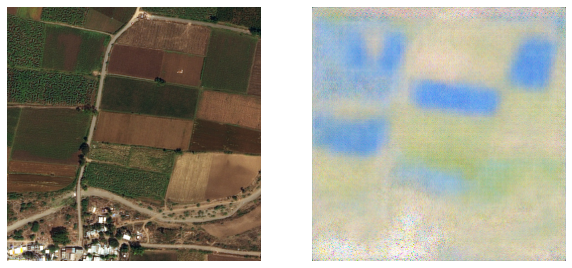

In [ ]:
src_path = '/content/drive/MyDrive/mapsSplit/trainSplit/sats/3.jpg'
src_path = '/content/drive/MyDrive/SU_Projekt/204190_sat.jpg'
src_image = load_image(src_path)
gen_image = m.predict(src_image)
src_sat = load_img(src_path)
#src_image = src_image*127.5 + 127.5
fig = plt.figure(figsize=(10, 7))
# setting values to rows and column variables
g_image = gen_image[0]*127.5+127.5
rows = 1
columns = 2
fig.add_subplot(rows, columns, 1)
plt.imshow(src_sat)
plt.axis('off')
fig.add_subplot(rows, columns, 2)
#plt.imshow(tf.cast(gen_image[0]*127.5+127.5, tf.uint8))
plt.imshow((gen_image[0]))
plt.axis('off')

In [ ]:
def generate_map(model, src_image):
  prediction = model.predict(src_image)